In [1]:
import json
import os
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statistics import mode

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import rioxarray

from xrspatial import focal, slope
import seaborn as sns
from tqdm import tqdm
from joblib_progress import joblib_progress
from xrspatial.multispectral import ndvi, savi
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection import RandomizedSearchCV as RSCV
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss


In [2]:
# paths
helena_path = Path.cwd().parent / 'data' / 'helena'
pred_path = helena_path / 'predictions.parquet'

In [3]:
# open crowns with predictions
pred_df = gpd.read_parquet(pred_path).set_index('UniqueID')

In [4]:
print(f'of {len(pred_df)} crowns:')
print(f'{((pred_df.pred_2020) > pred_df.pred_2018).sum()} increase probability of being alive between 2018 and 2020')
print(f'{((pred_df.pred_2022 > pred_df.pred_2020)).sum()} increase probability of being alive between 2020 and 2022')
print(f'{((pred_df.pred_2022 > pred_df.pred_2018)).sum()} increase probability of being alive between 2018 and 2022')

of 46685 crowns:
30413 increase probability of being alive between 2018 and 2020
13227 increase probability of being alive between 2020 and 2022
17438 increase probability of being alive between 2018 and 2022


<Axes: >

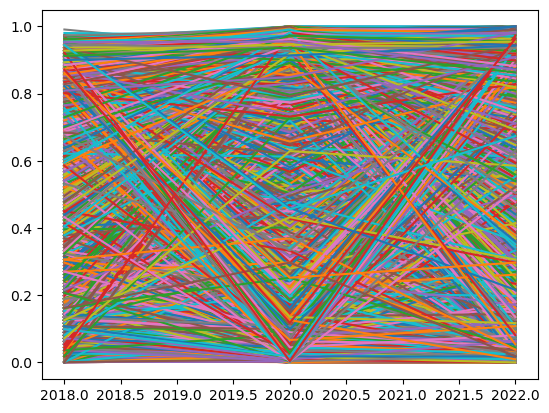

In [5]:
t_series = pred_df[['pred_2018', 'pred_2020', 'pred_2022']].T
t_series.index = 2018, 2020, 2022
t_series.plot(legend=False)

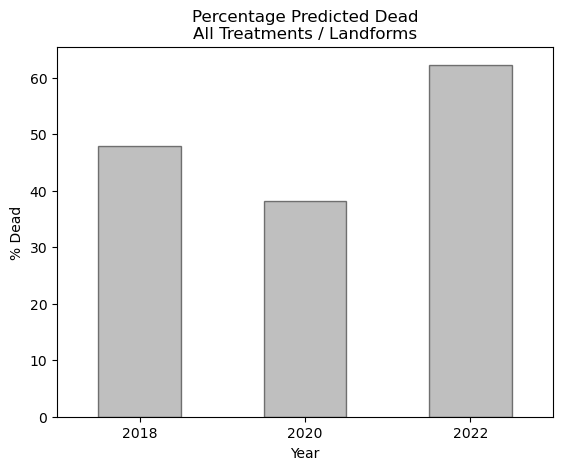

In [16]:
treatment_df = pred_df[['pred_2018', 'pred_2020', 'pred_2022']]
treatment_df.columns = ['2018', '2020', '2022']
tot = len(treatment_df)
alive_df = treatment_df[['2018', '2020', '2022']].round().sum()
(100 * (tot - alive_df) / tot).plot.bar(
    rot=0,
    facecolor='grey',
    edgecolor='k',
    alpha=0.5
    )
plt.xlabel('Year')
plt.ylabel('% Dead')
plt.title('Percentage Predicted Dead\nAll Treatments / Landforms');


In [7]:
pred_df.treatment.unique()

array([ 3,  0, 12, 15])

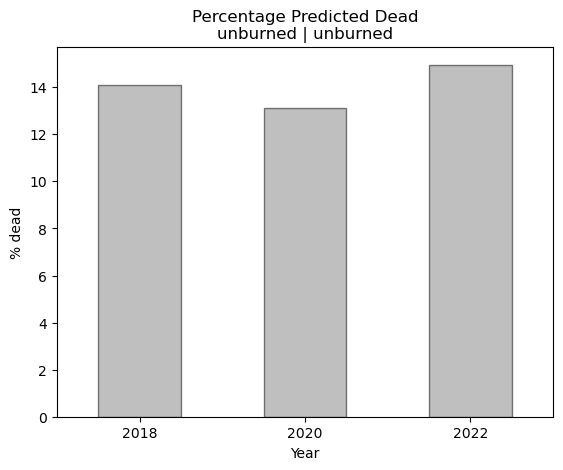

In [17]:
treatment = 0
treatment_df = pred_df[pred_df.treatment == treatment]
treatment_df = treatment_df[['pred_2018', 'pred_2020', 'pred_2022']]
treatment_df.columns = ['2018', '2020', '2022']
tot = len(treatment_df)
alive_df = treatment_df[['2018', '2020', '2022']].round().sum()
(100 * (tot - alive_df) / tot).plot.bar(
    rot=0,
    facecolor='grey',
    edgecolor='k',
    alpha=0.5
    )
plt.xlabel('Year')
plt.ylabel('% dead')
plt.title('Percentage Predicted Dead\nunburned | unburned');


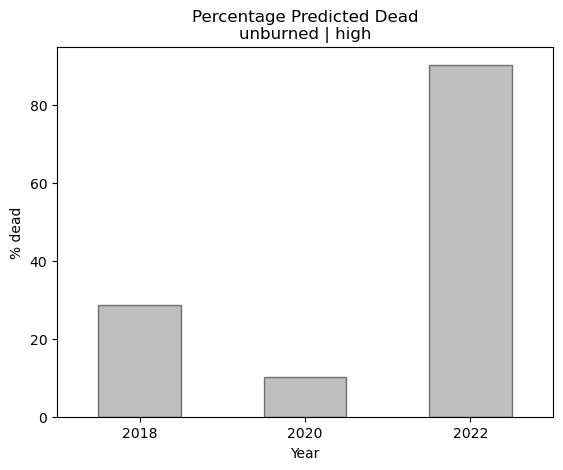

In [21]:
treatment = 3
treatment_df = pred_df[pred_df.treatment == treatment]
treatment_df = treatment_df[['pred_2018', 'pred_2020', 'pred_2022']]
treatment_df.columns = ['2018', '2020', '2022']
tot = len(treatment_df)
alive_df = treatment_df[['2018', '2020', '2022']].round().sum()
(100 * (tot - alive_df) / tot).plot.bar(
    rot=0,
    facecolor='grey',
    edgecolor='k',
    alpha=0.5
    )
plt.xlabel('Year')
plt.ylabel('% dead')
plt.title('Percentage Predicted Dead\nunburned | high');

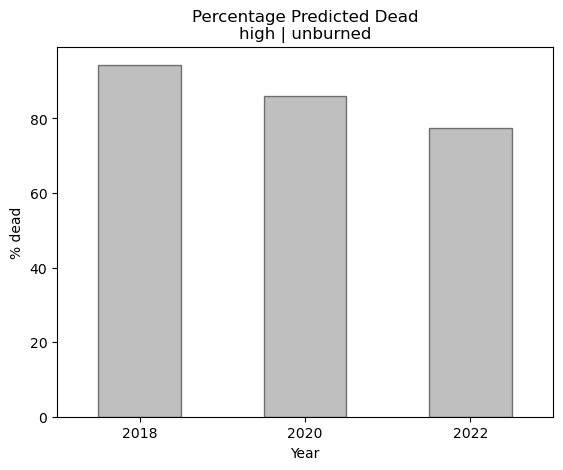

In [19]:
treatment = 12
treatment_df = pred_df[pred_df.treatment == treatment]
treatment_df = treatment_df[['pred_2018', 'pred_2020', 'pred_2022']]
treatment_df.columns = ['2018', '2020', '2022']
tot = len(treatment_df)
alive_df = treatment_df[['2018', '2020', '2022']].round().sum()
(100 * (tot - alive_df) / tot).plot.bar(
    rot=0,
    facecolor='grey',
    edgecolor='k',
    alpha=0.5
    )
plt.xlabel('Year')
plt.ylabel('% dead')
plt.title('Percentage Predicted Dead\nhigh | unburned');

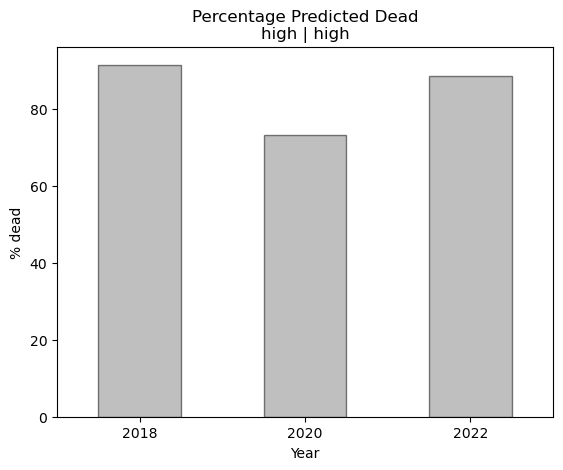

In [35]:
treatment = 15
treatment_df = pred_df[pred_df.treatment == treatment]
treatment_df = treatment_df[['pred_2018', 'pred_2020', 'pred_2022']]
treatment_df.columns = ['2018', '2020', '2022']
tot = len(treatment_df)
alive_df = treatment_df[['2018', '2020', '2022']].round().sum()
(100 * (tot - alive_df) / tot).plot.bar(
    rot=0,
    facecolor='grey',
    edgecolor='k',
    alpha=0.5
    )
plt.xlabel('Year')
plt.ylabel('% dead')
plt.title('Percentage Predicted Dead\nhigh | high');

![alt text](../img/r_geomorphon.png "Geomorphon codes")

In [37]:

morph_cols = [
    'geomorph_100',
    'geomorph_250',
    'geomorph_500',
    'geomorph_1000',
    'geomorph_2000'
]

pred_cols = [
    'pred_2018',
    'pred_2020',
    'pred_2022'
    ]

treatments = pred_df.treatment.unique()

lf_dict = {
    1: 'flat',
    2: 'summit',
    3: 'ridge',
    4: 'shoulder',
    5: 'spur',
    6: 'slope',
    7: 'hollow',
    8: 'footslope',
    9: 'valley',
    10: 'depression'   
}

In [ ]:
def sampler(mu):
    

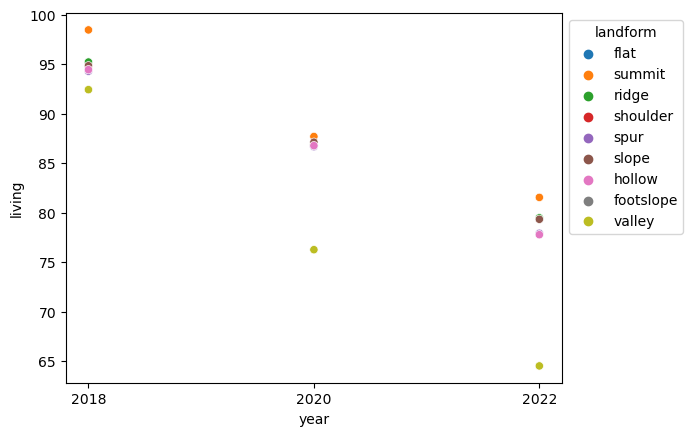

In [99]:
for morph in morph_cols:
    pass

morph = morph_cols[0]
landform = 3
cols = pred_cols + [morph]
r = morph.split('_')[-1]
treatment = 12

treatment_df = pred_df[pred_df.treatment == treatment][cols]
treatment_df.columns = ['2018', '2020', '2022', morph]

dfs = []
for lf in range(1, 10):
    geomorph_df = treatment_df[treatment_df[morph] == lf]
    df_ = pd.DataFrame(columns=['year', 'living', 'landform'])
    tot = len(geomorph_df)
    
    
    
    
    
    df_['year'] = geomorph_df[['2018', '2020', '2022']].round().sum().index.to_list()
    
    df_['living'] = geomorph_df[['2018', '2020', '2022']].round().sum().values
    df_['living'] = (100 * (tot - df_.living) / tot)
    df_['landform'] = lf_dict[lf]
    dfs.append(df_)
alive_df = pd.concat(dfs)

ax = sns.scatterplot(data=alive_df, x='year', y='living', hue='landform')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

In [98]:
pred_df.pred_2022

UniqueID
10N_483827_4524602    0.198198
10N_483828_4512551    0.099099
10N_483828_4514248    0.873504
10N_483829_4514263    0.818944
10N_483830_4510126    0.162162
                        ...   
10N_503153_4507702    0.943150
10N_503154_4513953    0.297297
10N_503155_4518180    0.863307
10N_503160_4516232    0.963373
10N_503162_4515300    0.871173
Name: pred_2022, Length: 46685, dtype: float64